**The commands below only work with later commands executed in the same terminal session**

In [ ]:
export GCP_PROJECT_ID="replace-me-with-your-project-id"
export DOCKER_IMAGE_NAME="name-of-my-image-in-kebab-case"
export GCR_MULTI_REGION="eu.gcr.io"
export GCR_REGION="europe-west1"


Updating the Dockerfile for GCR

⚠️ Remember that Uvicorn starts by default on port 8000 ? Well Google Cloud Run requires that the servers running inside of its containers run on a very specific port defined by the $PORT environment variable. This allows GCR to monitor the code and restart the container if the server crashes.

👉 In order to do that, we need to update our image so that Uvicorn listens to the $PORT port using the --port parameter

In [ ]:
FROM python:3.8.6-buster

COPY api /api
COPY project /project
COPY model.joblib /model.joblib
COPY requirements.txt /requirements.txt

RUN pip install --upgrade pip
RUN pip install -r requirements.txt

CMD uvicorn api.simple:app --host 0.0.0.0 --port $PORT

**Build our image for Container Registry**

Once we have updated the Dockerfile in order to match the $PORT used by Cloud Run, we can build our image one last time:

In [ ]:
docker build -t $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME .

We want to make sure that our modifications are working correctly before pushing our image. But in order for our Dockerfile to work correctly, we need to define the $PORT environment variable ourselves by using -e PORT=8000 :

In [ ]:
docker run -e PORT=8000 -p 8080:8000 $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME

When we test this new image locally, the -e PORT=8000 parameter allows us to define the $PORT environment variable that is now expected by uvicorn in the CMD directive of the Dockerfile.

👉 Let's verify that everything is ok on http://localhost:8080/

**Push our image to Container Registry**

Finally, we can push the Container Registry specific image to Container Registry:

In [ ]:
docker push $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME

**Deploy our image to Cloud Run**

Once our image is stored on Container Registry, deploying our code using Cloud Run is easy :

In [ ]:
gcloud run deploy --image $GCR_MULTI_REGION/$GCP_PROJECT_ID/$DOCKER_IMAGE_NAME --platform managed --region $GCR_REGION

**Disable Your API**

When you want to stop an API, you need to go to the Google Cloud Run console and delete the service (the running API container)

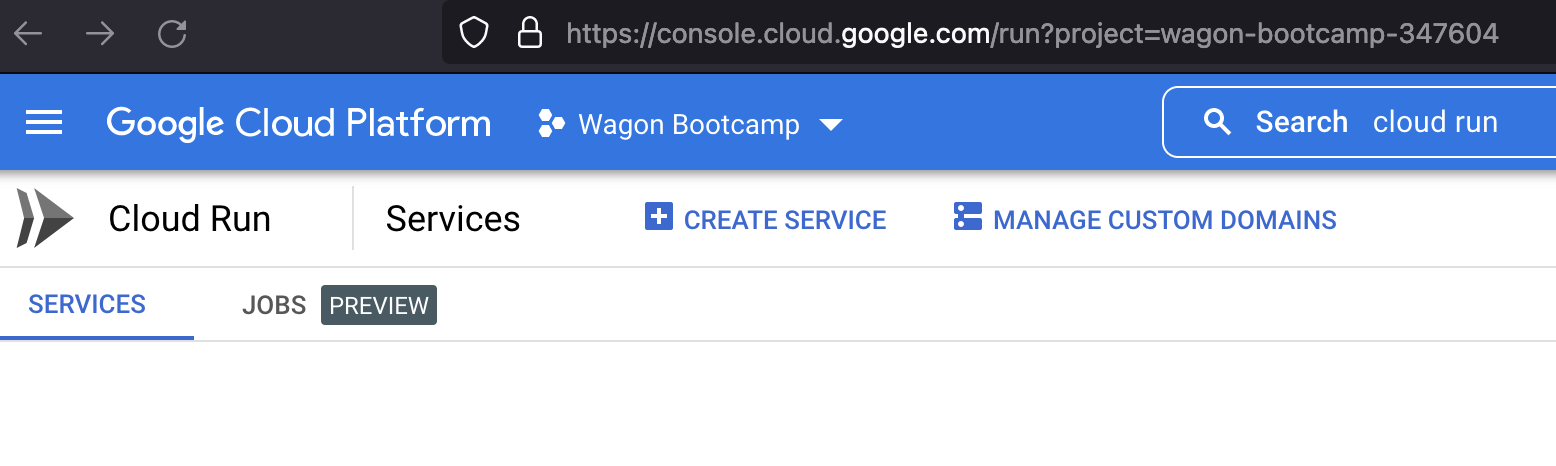

You can also run existing images you've uploaded to container registry from here via the "Create Service" option at the top.